In [1]:
from collections import defaultdict
import numpy as np
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
%matplotlib inline

# Data

In [2]:
d = 11
A = np.random.normal(size = (d, 10))
b = np.random.uniform(1, 0, d)

or use a real dataset in LibSVM format

In [3]:
A, b = load_svmlight_file("../data/ionosphere.txt")

# Helper function

In [4]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

# Stochastic gradient descent for Lasso

In [5]:
def lasso_function(A, b, reg_coef, alpha):
    return 0.5 * np.linalg.norm(A.dot(alpha) - b) ** 2 + reg_coef * np.sum(np.abs(alpha))

In [6]:
def compute_stoch_gradient_lasso(A, b, reg_coef, alpha):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    err = b - A.dot(alpha)
    gradient = - A.T.dot(err) + reg_coef * np.sign(alpha) * A.shape[0]
    return gradient

In [7]:
def stochastic_gradient_descent_lasso(A, b, reg_coef, gamma, batch_size=1, max_iter=1000, trace=False):
    history = defaultdict(list) if trace else None
    
    num_data_points, num_features = np.shape(A)
    alpha_t = np.zeros(num_features)
    
    start_time = time.time()
    
    for current_iter in range(0, max_iter):
        if trace:
            history['time'].append(time.time() - start_time)
            history['objective_function'].append(lasso_function(A, b, reg_coef, alpha_t))
        for b_batch, A_batch in batch_iter(b, A, batch_size=batch_size, num_batches=1):
            gradient = compute_stoch_gradient_lasso(A_batch, b_batch, reg_coef / num_data_points, alpha_t)
            alpha_t = alpha_t - gamma * gradient
    return alpha_t, history

In [8]:
x_t, history = stochastic_gradient_descent_lasso(A, b, 0.1, 0.005, max_iter=5000, trace=True, batch_size=1)

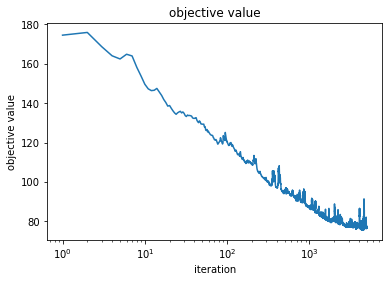

In [9]:
plt.semilogx(history['objective_function']) # log scale
plt.xlabel("iteration")
plt.ylabel("objective value")
plt.title("objective value")

# Coordinate Descent for Lasso

In [10]:
def soft_threshold(internal, reg_coef, current_feature_norm):
    if internal > reg_coef:
        return (internal - reg_coef) / (current_feature_norm ** 2)
    elif internal < - reg_coef:
        return (internal + reg_coef) / (current_feature_norm ** 2)
    return 0.0

In [11]:
def coordinate_descent_lasso(A, b, reg_coef, max_iter=1000, trace=False, is_check=False,
                             check_epsilon=1e-1):
    history = defaultdict(list) if trace else None

    num_features = np.shape(A)[1]
    alpha_t = np.zeros(num_features)
    residual = np.copy(b)

    start_time = time.time()

    for current_iter in range(0, max_iter):
        if trace:
            history['time'].append(time.time() - start_time)
            history['objective_function'].append(lasso_function(A, b, reg_coef, alpha_t))
        i = np.random.randint(0, num_features)
        if sps.issparse(A):
            current_feature = np.array(A[:, i].todense())
        else:
            current_feature = np.array(A[:, i])

        current_feature_norm = np.linalg.norm(current_feature)
        if current_feature_norm == 0:
            alpha_t[i] = 0
            continue
        internal = (residual.reshape(-1)).dot(current_feature.reshape(-1)
                    ) + alpha_t[i] * (current_feature_norm ** 2)
        new_value = soft_threshold(internal, reg_coef, current_feature_norm)
        residual += (current_feature * (alpha_t[i] - new_value)).reshape(residual.shape)
        alpha_t[i] = np.copy(new_value)

        if is_check:  # optional check if a slightly smaller or larger step would indeed make the function value worse
            alpha_t_epsilon = np.zeros_like(alpha_t)
            alpha_t_epsilon[i] = check_epsilon
            if ((lasso_function(A, b, reg_coef, alpha_t + alpha_t_epsilon) <
                            lasso_function(A, b, reg_coef, alpha_t)) or (
                            lasso_function(A, b, reg_coef, alpha_t - alpha_t_epsilon) <
                            lasso_function(A, b, reg_coef, alpha_t))):
                print("ERROR!")
                print("iteration:", current_iter)
                print("objective function:\t", lasso_function(A, b, reg_coef, alpha_t))
                print("\t+eps:\t", lasso_function(A, b, reg_coef, alpha_t + alpha_t_epsilon))
                print("\t-eps:\t", lasso_function(A, b, reg_coef, alpha_t - alpha_t_epsilon))
                print("current_feature_norm:", current_feature_norm)
                print("internal:", internal)
                print("alpha_t=", alpha_t[i])
                print("feature indexes:", i)
    return alpha_t, residual, history

And finally run the optimization algorithm

In [12]:
x_t, residual, history = coordinate_descent_lasso(A, b, 0.1, max_iter=1000, trace=True,
                                                  is_check=True, check_epsilon=1e-6)

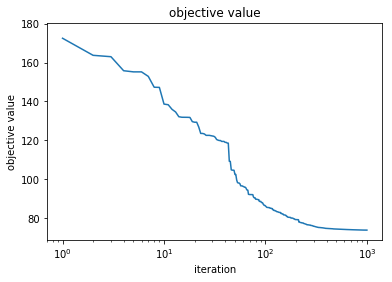

In [13]:
plt.semilogx(history['objective_function'])
plt.xlabel("iteration")
plt.ylabel("objective value")
plt.title("objective value")